In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 16
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\USER\Downloads\pestsdataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6243 files belonging to 6 classes.


In [4]:
class_names = dataset.class_names
class_names

['cashew_leaf miner',
 'cassava_green mite',
 'maize_fall armyworm',
 'maize_grasshoper',
 'maize_leaf beetle',
 'rice_hispa']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 224, 224, 3)
[5 3 0 3 1 5 1 0 3 1 3 2 5 3 2 0]


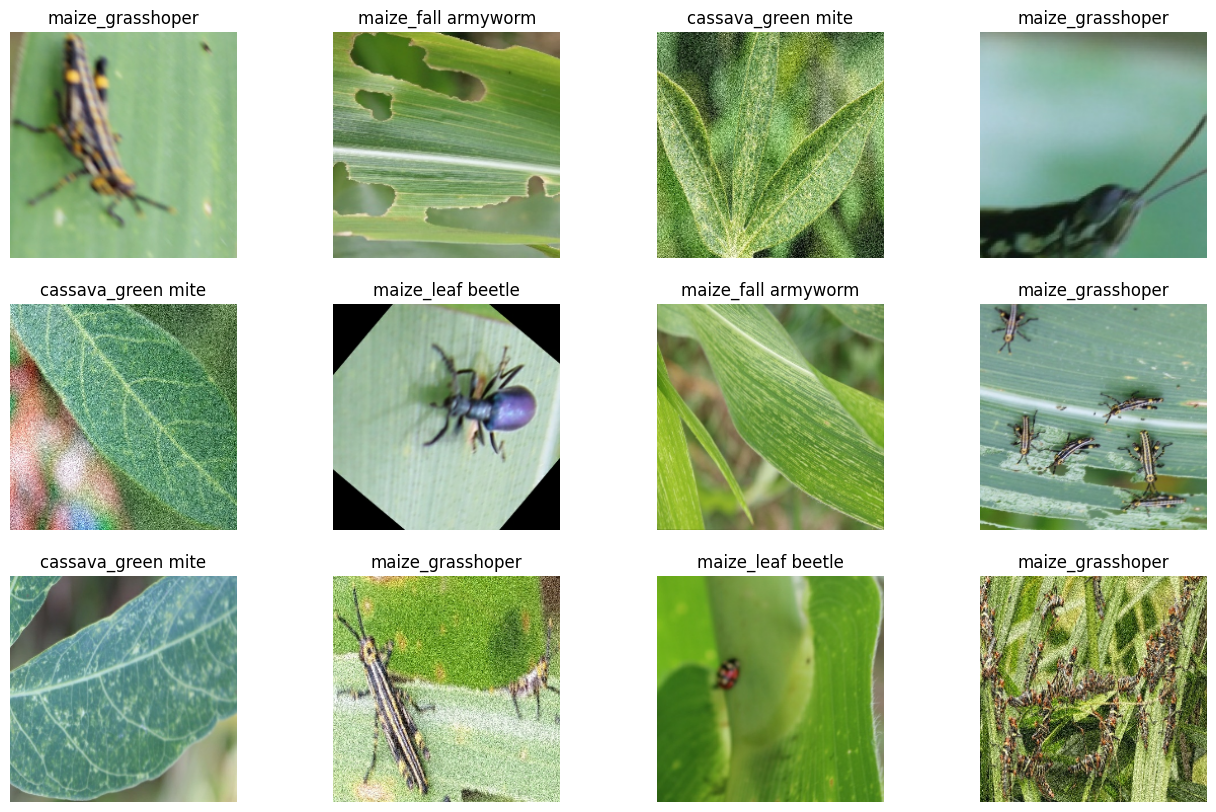

In [6]:
plt.figure(figsize=(16, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

391

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

312

In [11]:
len(val_ds)

39

In [12]:
len(test_ds)

40

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  
])

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Add dropout for regularization
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 222, 222, 32)        896       
                                                                 
 batch_normalization (Batch  (16, 222, 222, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (16, 111, 111, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 109, 109, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (16, 109, 109, 64)       

In [19]:
from keras.optimizers import Adam

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    
  # Add class weights here
)


In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
312/312 [==============================] - 591s 2s/step - loss: 1.2229 - accuracy: 0.5541 - val_loss: 1.8234 - val_accuracy: 0.3558
Epoch 2/10
312/312 [==============================] - 470s 2s/step - loss: 0.8974 - accuracy: 0.6847 - val_loss: 0.7633 - val_accuracy: 0.7179
Epoch 3/10
312/312 [==============================] - 463s 1s/step - loss: 0.7606 - accuracy: 0.7208 - val_loss: 3.5149 - val_accuracy: 0.3510
Epoch 4/10
312/312 [==============================] - 494s 2s/step - loss: 0.6487 - accuracy: 0.7728 - val_loss: 0.5624 - val_accuracy: 0.7821
Epoch 5/10
312/312 [==============================] - 527s 2s/step - loss: 0.5970 - accuracy: 0.7827 - val_loss: 0.5678 - val_accuracy: 0.7804
Epoch 6/10
312/312 [==============================] - 554s 2s/step - loss: 0.5226 - accuracy: 0.8161 - val_loss: 0.4235 - val_accuracy: 0.8494
Epoch 7/10
312/312 [==============================] - 513s 2s/step - loss: 0.5022 - accuracy: 0.8179 - val_loss: 0.7068 - val_accuracy: 0.7564

In [21]:

# scores = model.evaluate(test_ds)

test_loss, test_accuracy = model.evaluate(test_ds)

40/40 [==============================] - 39s 331ms/step - loss: 0.3231 - accuracy: 0.8813


In [22]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.32309359312057495
Test Accuracy: 0.8812500238418579


In [23]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have the model predictions and true labels
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(conf_matrix)


40/40 [==============================] - 14s 310ms/step
Confusion Matrix:
[[15 21 17 13 15 13]
 [22 16 18 19 11 22]
 [16 25 18 17 10 20]
 [22 24 26 26 14 29]
 [ 8 10 13 14 18 12]
 [12 21 25 24 16 18]]


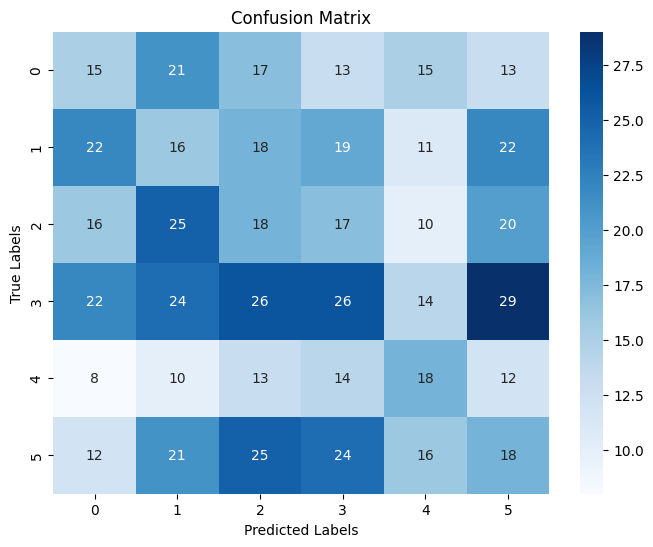

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

num_classes = 6
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
# Generate classification report
class_report = classification_report(y_true, y_pred)

print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.16      0.16        94
           1       0.14      0.15      0.14       108
           2       0.15      0.17      0.16       106
           3       0.23      0.18      0.20       141
           4       0.21      0.24      0.23        75
           5       0.16      0.16      0.16       116

    accuracy                           0.17       640
   macro avg       0.18      0.18      0.18       640
weighted avg       0.18      0.17      0.17       640



In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 312}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
type(history.history['loss'])

list

In [30]:
len(history.history['loss'])

10

In [31]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.2229067087173462,
 0.8974049687385559,
 0.7606332302093506,
 0.64869624376297,
 0.5969999432563782]

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

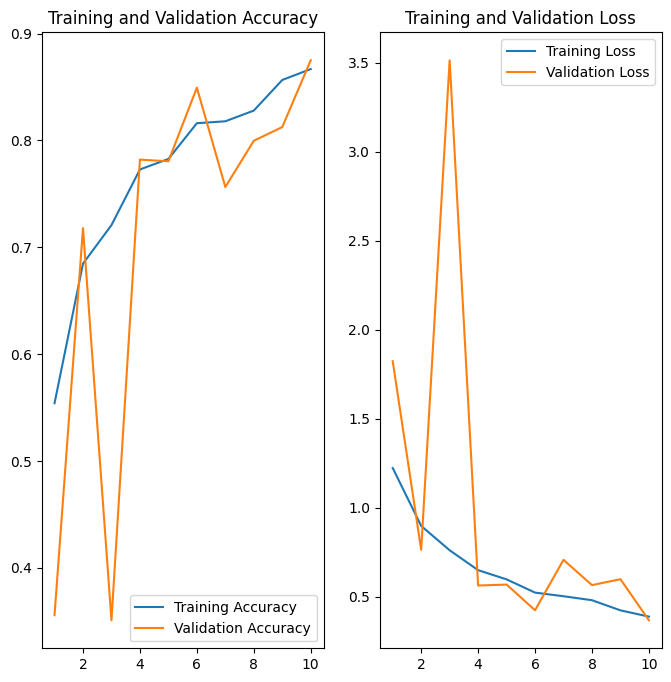

In [33]:
# Get the actual number of epochs from the length of acc (assuming acc has the same length as EPOCHS)
EPOCHS = len(acc)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), acc, label='Training Accuracy')  
plt.plot(range(1, EPOCHS + 1), val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), loss, label='Training Loss')  
plt.plot(range(1, EPOCHS + 1), val_loss, label='Validation Loss') 
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

first image to predict
actual label: maize_grasshoper
1/1 [==============================] - 1s 534ms/step
predicted label: maize_grasshoper


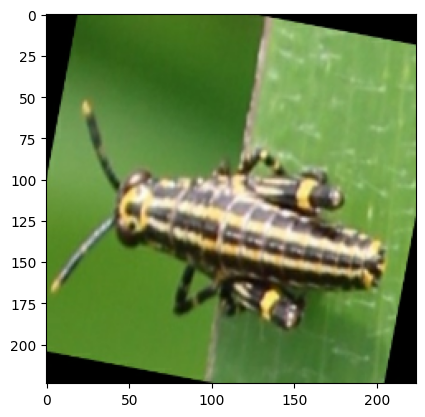

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = resize_and_rescale(img_array)  # Apply the same preprocessing as during training

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 47ms/step


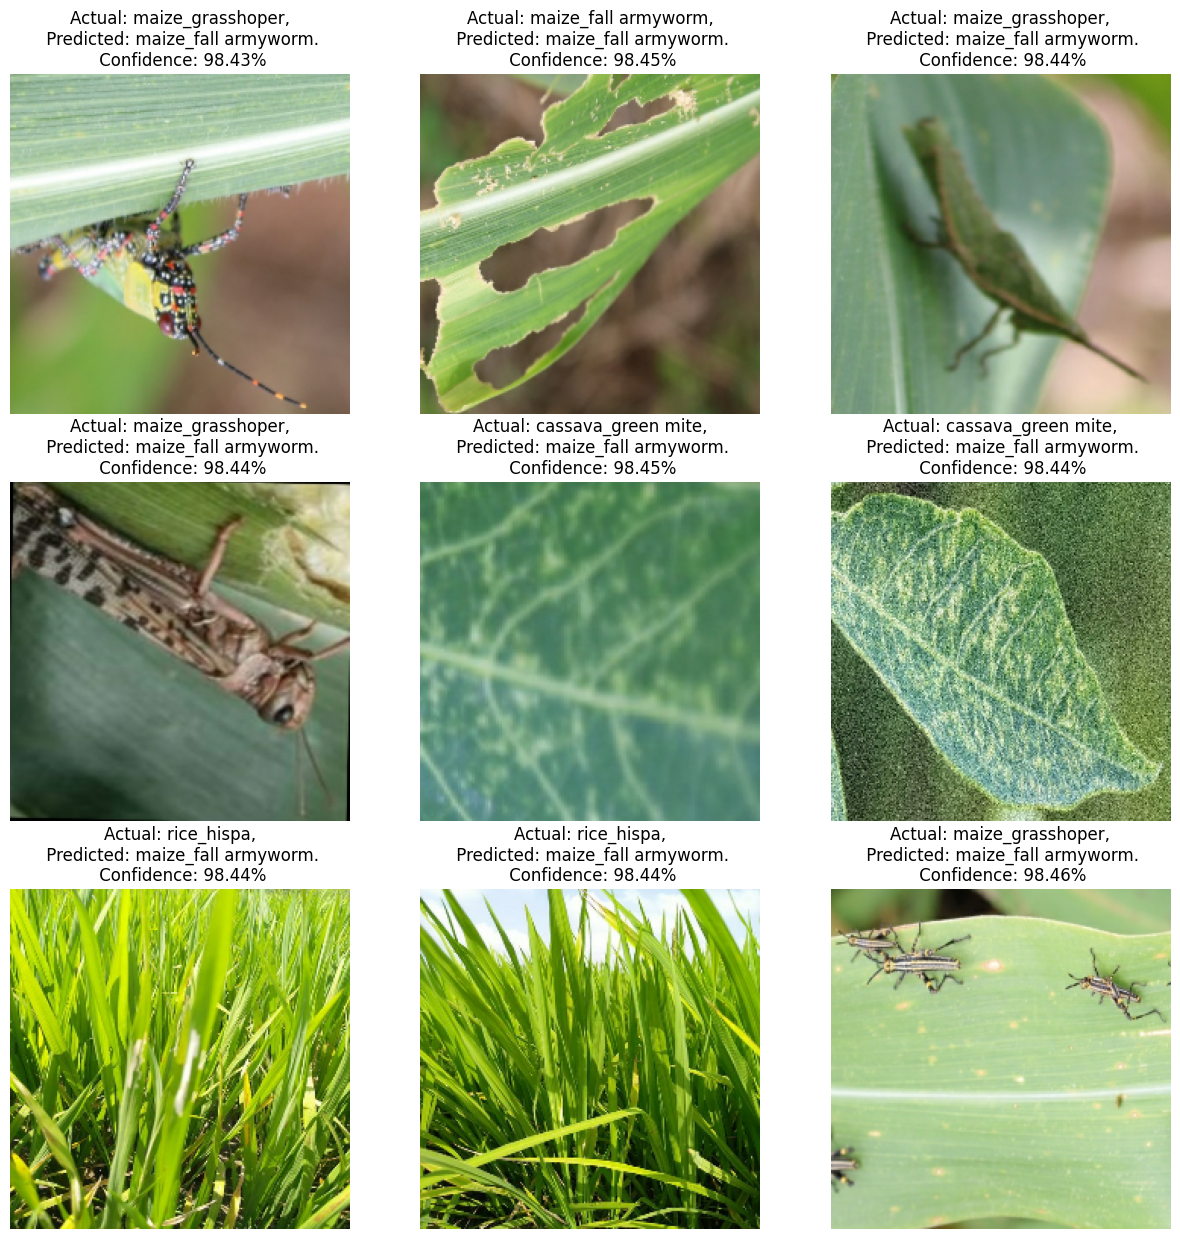

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [37]:
import os

# Get all directories in "../models"
directory_path = r"C:\Users\USER\Downloads\DSGPgit\DSGP\pestmodels"
directories = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]

# Extract numeric parts from directory names
versions = [int(''.join(filter(str.isdigit, d))) for d in directories if any(char.isdigit() for char in d)]

# Find the maximum version number
model_version = max(versions + [0]) + 1

# Save the model
model.save(os.path.join(directory_path, str(model_version), "pests.h5"))


C:\Users\USER\anacondaa\envs\myyenv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
